# GTEx Published vs GTEx Reprocessed (v32 GDC workflow) DESeq2 Analysis

Three normal "whole blood" non-cancerous tissue samples from GTEx are used to compare their counts published from their GTEx/[Broad Instititute Workflow](https://github.com/broadinstitute/gtex-pipeline/tree/master/rnaseq) vs [GDC's v32 workflow](https://docs.gdc.cancer.gov/Data/Bioinformatics_Pipelines/Expression_mRNA_Pipeline/). GTEx samples used are N7MS, NFK9, and O5YT.

Analysis included in this workflow:
- Pearson correlation
- DESeq2 differential expression
- Relative change
    - Histogram distributions
    - Quantiles


## Installing and loading packages

In [1]:
# Install packages if necessary
if (!require("dplyr", quietly = TRUE))
    install.packages("dplyr")
install.packages("tidyverse")
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install("EnhancedVolcano", dependencies = T)
BiocManager::install("DESeq2", dependencies = T)

# Import libraries
library(dplyr)
library(DESeq2)

# In the case EnhancedVolcano fails to install using BiocManager, pull the package off of github
if (!require("EnhancedVolcano", quietly = TRUE))
    devtools::install_github('kevinblighe/EnhancedVolcano')
library("EnhancedVolcano")


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




package 'tidyverse' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\bryce\AppData\Local\Temp\RtmpWU4miS\downloaded_packages


Bioconductor version '3.14' is out-of-date; the current release version '3.16'
  is available with R version '4.2'; see https://bioconductor.org/install

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.r-project.org


Bioconductor version 3.14 (BiocManager 1.30.19), R 4.1.3 (2022-03-10)

Warning message:
"package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'EnhancedVolcano'"
Old packages: 'Matrix', 'RcppArmadillo', 'roxygen2', 'stringi'

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.r-project.org


Bioconductor version 3.14 (BiocManager 1.30.19), R 4.1.3 (2022-03-10)

Warning message:
"package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'DESeq2'"
Old packages: 'Matrix', 'Rc

## Loading count files and formatting into one dataframe

In [2]:
# Load counts files
setwd(dir = "GTEx_counts/")
filenames <- list.files(pattern = "ed.txt", all.files = T, full.names = T)
filenames

# Store all counts data in list of dataframes
counts <- list()
for (i in seq_along(filenames)) {
    counts[[i]] <- read.table(file = filenames[i], header = T, sep = "\t")
}

# names(counts) <- list.files(pattern = "counts.counts", all.files = T)
# names(counts)

# Merge all dataframes in list into one dataframe based on "genes" column
counts.df <- Reduce(function(...) merge(..., by = 'genes'), counts)
head(counts.df)

# Make genes column as row names, remove from dataframe
dimnames(counts.df)[[1]] <- counts.df[,1]
counts.df <- counts.df[, -1]

head(counts.df)

# Reset work directory
setwd(dir = "..")

[1] "./N7MS_published.txt"   "./N7MS_reprocessed.txt" "./NFK9_published.txt"  
[4] "./NFK9_reprocessed.txt" "./O5YT_published.txt"   "./O5YT_reprocessed.txt"

,genes,GTExN7MScountsPUBLISHED,GTExN7MScountsREPROCESSED,GTExNFK9countsPUBLISHED,GTExNFK9countsREPROCESSED,GTExO5YTcountsPUBLISHED,GTExO5YTcountsREPROCESSED
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>
1,ENSG00000001167.14,1329,735,674,363,1040,574
2,ENSG00000002549.12,836,474,956,542,2829,1537
3,ENSG00000002822.15,960,69,1035,71,600,15
4,ENSG00000003096.14,8,4,28,16,6,7
5,ENSG00000003137.8,4,7,5,6,6,7
6,ENSG00000004777.18,485,291,287,180,168,112


,GTExN7MScountsPUBLISHED,GTExN7MScountsREPROCESSED,GTExNFK9countsPUBLISHED,GTExNFK9countsREPROCESSED,GTExO5YTcountsPUBLISHED,GTExO5YTcountsREPROCESSED
,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000001167.14,1329,735,674,363,1040,574
ENSG00000002549.12,836,474,956,542,2829,1537
ENSG00000002822.15,960,69,1035,71,600,15
ENSG00000003096.14,8,4,28,16,6,7
ENSG00000003137.8,4,7,5,6,6,7
ENSG00000004777.18,485,291,287,180,168,112


In [3]:
## Export dataframe as csv and txt
write.csv(counts.df, "GTEx published vs reprocessed all.csv", row.names = F)
write.table(counts.df, "GTEx published vs processed all.txt", row.names = F, sep = "\t")

## Quick Pearson correlation coefficient calculation between published and reprocessed

In [4]:
print("Pearson's correlation for N7MS:")
cor(counts.df$GTExN7MScountsPUBLISHED, counts.df$GTExN7MScountsREPROCESSED, method = "pearson")

print("Pearson's correlation for NFK9:")
cor(counts.df$GTExNFK9countsPUBLISHED, counts.df$GTExNFK9countsREPROCESSED, method = "pearson")

print("Pearson's correlation for O5YT:")
cor(counts.df$GTExO5YTcountsPUBLISHED, counts.df$GTExO5YTcountsREPROCESSED, method = "pearson")

[1] "Pearson's correlation for N7MS:"


[1] 0.9574927

[1] "Pearson's correlation for NFK9:"


[1] 0.95441

[1] "Pearson's correlation for O5YT:"


[1] 0.9939075

## DESeq2 setup

In [5]:
# A function to create annotation dataframe from dataframe input, returns the annotation dataframe
createAnnotations <- function(df) {
    colName <- colnames(df)
    condition <- vector()
    for (col in colName) {
        if (grepl("PUBLISHED", col, fixed = T)) {
            # column is PUBLISHED, label as "published"
            condition <- append(condition, "published")
        } else {
            # column is GTEx, label as "reprocessed"
            condition <- append(condition, "reprocessed")
        }
    }
    
    return (data.frame(colName, condition))
}

# Create annotation table for DESeq2
counts.df.meta <- createAnnotations(counts.df)
counts.df.meta

colName,condition
<chr>,<chr>
GTExN7MScountsPUBLISHED,published
GTExN7MScountsREPROCESSED,reprocessed
GTExNFK9countsPUBLISHED,published
GTExNFK9countsREPROCESSED,reprocessed
GTExO5YTcountsPUBLISHED,published
GTExO5YTcountsREPROCESSED,reprocessed


## Perform DESeq2, alpha = 0.05

In [6]:
# A function to get DESEQDataSet (dds) and perform DESeq on it, returns the dds after DESeq
performDeseq <- function(countDf, colDf) {
    dds <- DESeqDataSetFromMatrix(countData = round(countDf), colData = colDf, design= ~ condition)
    dds <- DESeq(dds)
    return (dds)
}

counts.dds <- performDeseq(counts.df, counts.df.meta)

# Get the result from DESeq2 into dataframe, alpha = 0.05
counts.dds.res <- results(counts.dds, alpha = 0.05)

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
"some variables in design formula are characters, converting to factors"
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [7]:
counts.dds.res

log2 fold change (MLE): condition reprocessed vs published 
Wald test p-value: condition reprocessed vs published 
DataFrame with 35117 rows and 6 columns
                     baseMean log2FoldChange     lfcSE      stat      pvalue
                    <numeric>      <numeric> <numeric> <numeric>   <numeric>
ENSG00000001167.14  762.51222      -0.397207  0.654008 -0.607343 5.43623e-01
ENSG00000002549.12 1034.81695      -0.376314  0.653559 -0.575792 5.64756e-01
ENSG00000002822.15  431.45537      -3.506689  0.875479 -4.005453 6.18987e-05
ENSG00000003096.14   12.78781      -0.225824  1.193510 -0.189210 8.49928e-01
ENSG00000003137.8     6.11739       0.910644  1.184959  0.768503 4.42189e-01
...                       ...            ...       ...       ...         ...
ENSG00000284591.1    0.000000             NA        NA        NA          NA
ENSG00000284594.1    0.859461       3.458288   3.96900  0.871324    0.383577
ENSG00000284595.1    0.000000             NA        NA        NA          N

In [8]:
# Number of genes with p-adjusted value under 0.05
sum(counts.dds.res$padj < 0.05, na.rm = T)

# out of how many genes
dim(counts.df)

[1] 197

[1] 35117     6

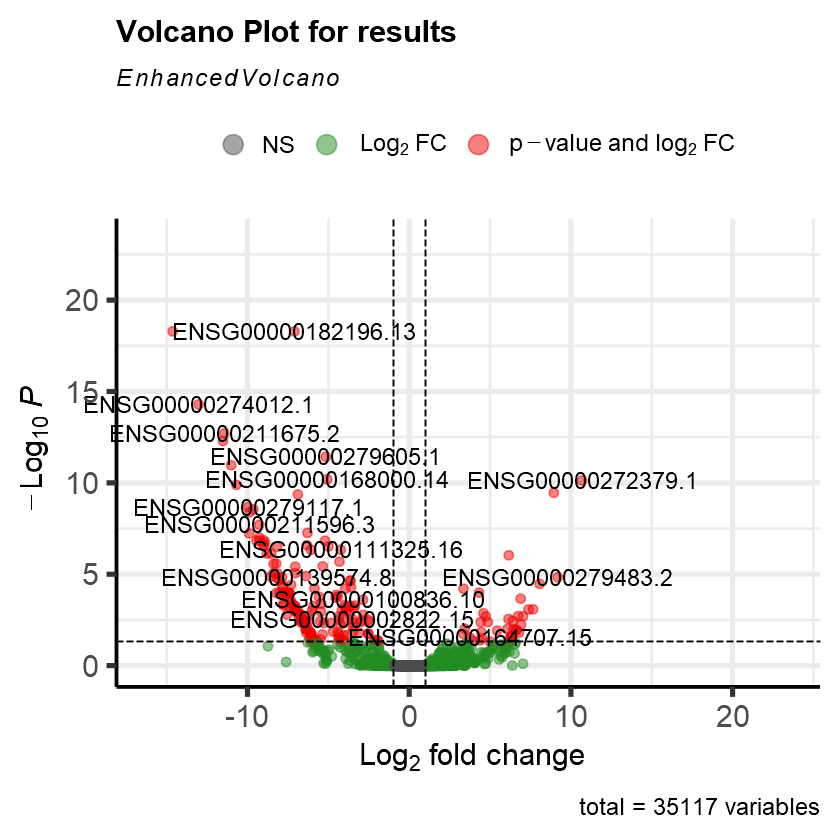

In [9]:
# Make a volcano plot for results
EnhancedVolcano(counts.dds.res,
    lab = rownames(counts.dds.res),
    title = "Volcano Plot for results",
    x = 'log2FoldChange',
    y = 'padj',
    pCutoff = 0.05)

## Relative Change between samples

Relative change between the reprocessed and published counts for each sample. Formula used is `abs((reprocessed - published)) / published`, and quantiles of those relative change difference values are measured. Histogram of differences distribution is included.

### N7MS

,GTExN7MScountsPUBLISHED,GTExN7MScountsREPROCESSED
,<int>,<int>
ENSG00000001167.14,1329,735
ENSG00000002549.12,836,474
ENSG00000002822.15,960,69
ENSG00000003096.14,8,4
ENSG00000003137.8,4,7
ENSG00000004777.18,485,291


[1] "Quantile:"


0%         10%         25%         50%         75%         90% 
  0.0000000   0.0000000   0.2500000   0.4412586   0.5570136   1.0000000 
       100% 
194.0000000

[1] "Gene Statistics (difference total, difference > 0.5 to >10):"


[1] 8592

[1] 2304

[1] 591

[1] 86

[1] 34

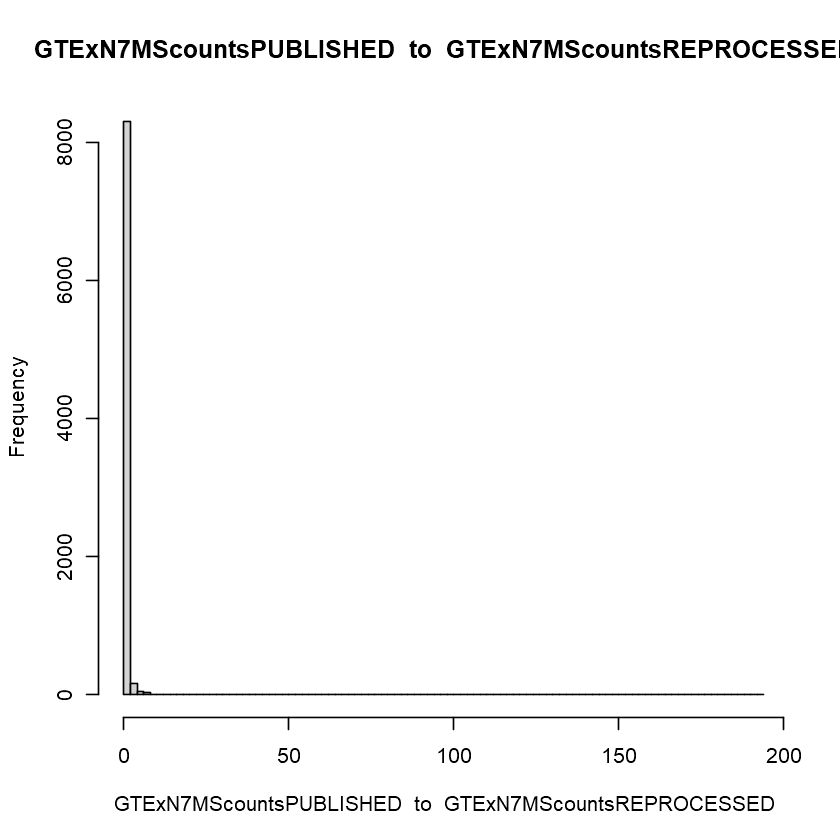

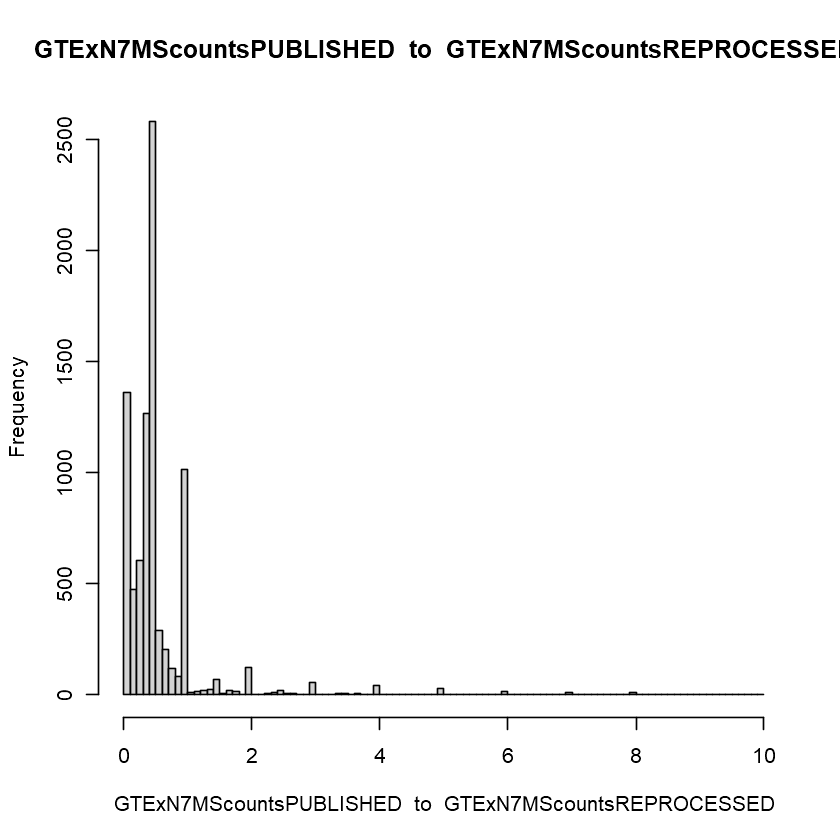

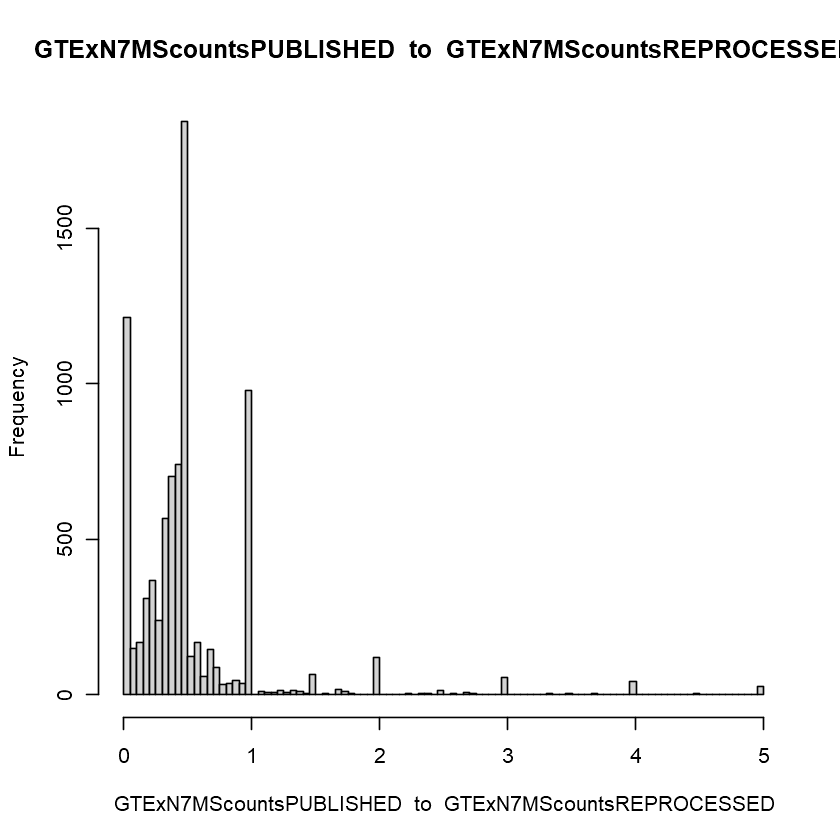

In [10]:
n7ms <- counts.df[,c(1,2)]
head(n7ms)

df <- n7ms
published <- 1
reprocessed <- 2

# Separate vectors for non-NA values and would-be NA values (dividng by zero)
difference <- vector()
tozero <- vector()

name <- paste(colnames(df)[published], " to ", colnames(df)[reprocessed])

# Calculate relative change for each gene
for (k in 1:nrow(df)) {
    if (df[k, published] == 0) { # "divide by zero" results in a seperate vector
        tozero <- append(tozero, df[k, reprocessed])
    } else {
        # relative change value calculated and stored in vector
        change <- abs(df[k, reprocessed] - df[k, published]) / df[k, published]
        difference <- append(difference, change)
    }
}

# histogram for all genes
hist(difference, main = name, xlab = name, nclass = 100)

# quantile
print("Quantile:")
quantile(difference, probs=c(0, 0.1, 0.25, 0.5, 0.75, 0.9, 1))

# number of genes statistics
print("Gene Statistics (difference total, difference > 0.5 to >10):")
length (difference)
length(which (difference > 0.5))
length(which (difference > 1))
length(which (difference > 5))
length(which (difference > 10))

# histogram for > 10 difference genes
rm.ind <- which (difference > 10)
difference2 <- difference[-rm.ind]

hist(difference2, main = name, xlab = name, nclass = 100)

# histogram for > 5 difference genes
rm.ind <- which (difference > 5)
difference3 <- difference[-rm.ind]
hist(difference3, main = name, xlab = name, nclass=100)

### NFK9

,GTExNFK9countsPUBLISHED,GTExNFK9countsREPROCESSED
,<int>,<int>
ENSG00000001167.14,674,363
ENSG00000002549.12,956,542
ENSG00000002822.15,1035,71
ENSG00000003096.14,28,16
ENSG00000003137.8,5,6
ENSG00000004777.18,287,180


[1] "Quantile:"


0%        10%        25%        50%        75%        90%       100% 
 0.0000000  0.0000000  0.3030303  0.4516129  0.7500000  1.0000000 55.1111111

[1] "Gene Statistics (difference total, difference > 0.5 to >10):"


[1] 7092

[1] 2300

[1] 519

[1] 65

[1] 16

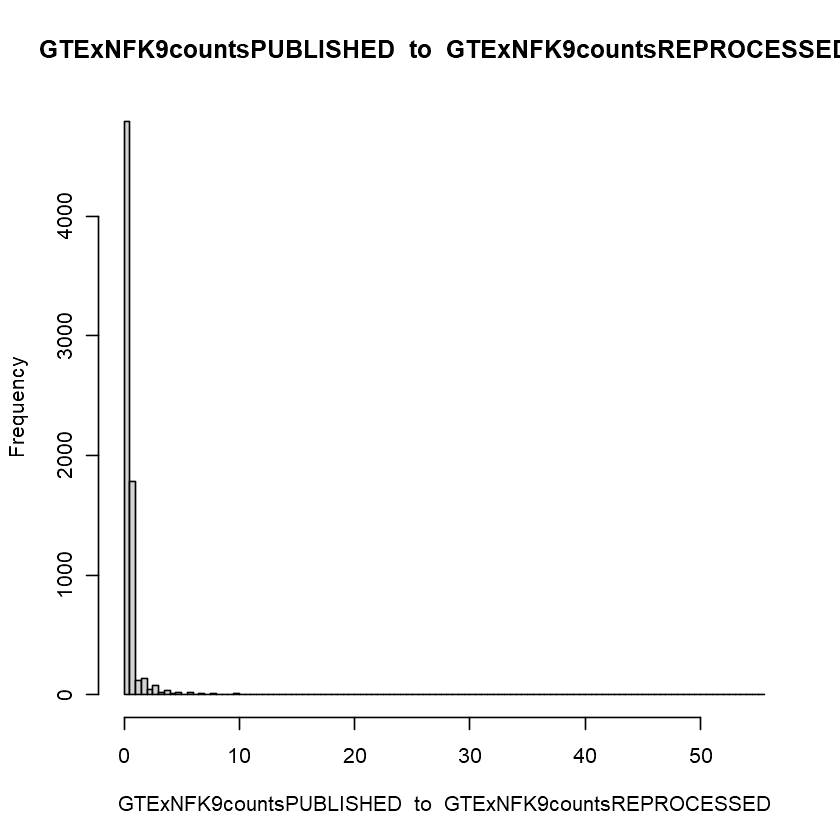

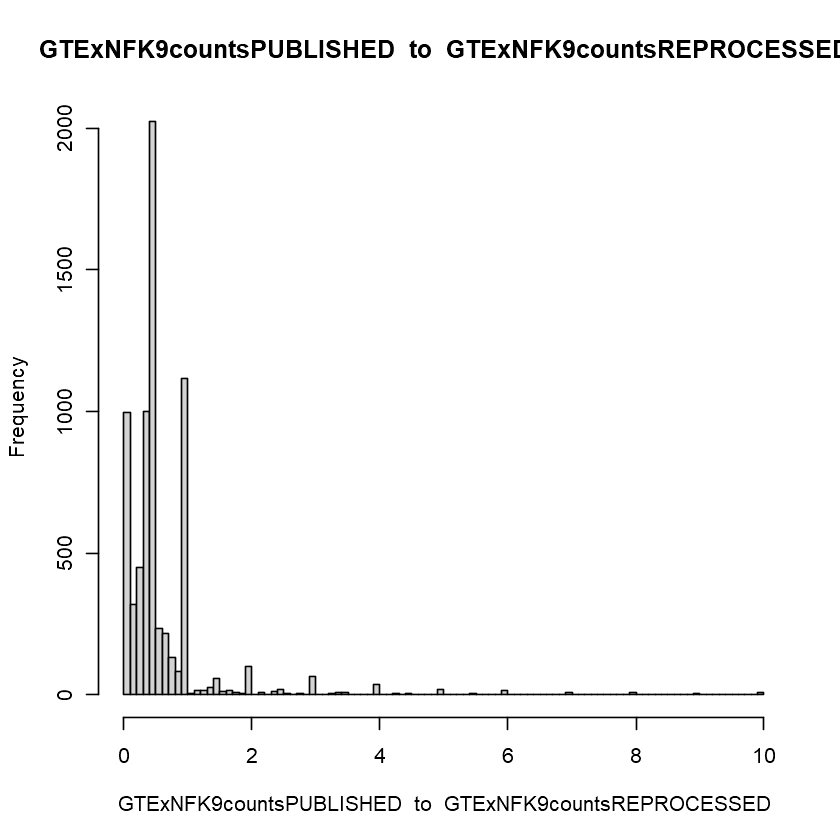

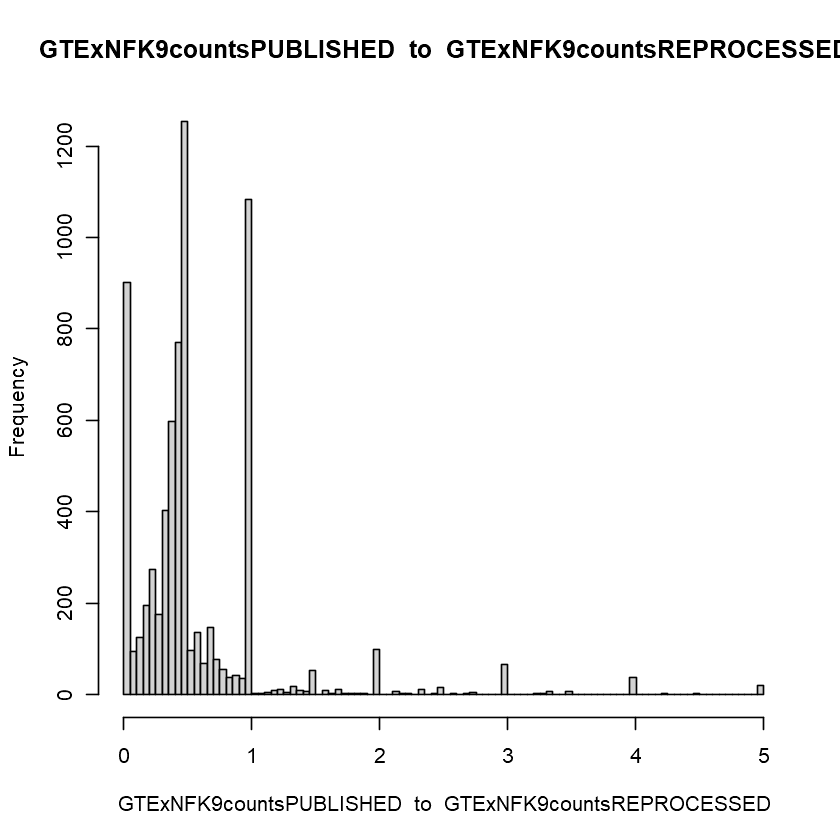

In [11]:
nfk9 <- counts.df[,c(3,4)]
head(nfk9)

df <- nfk9
published <- 1
reprocessed <- 2

difference <- vector()
tozero <- vector()

name <- paste(colnames(df)[published], " to ", colnames(df)[reprocessed])

for (k in 1:nrow(df)) {
    if (df[k, published] == 0) { # "divide by zero" results in a seperate vector
        tozero <- append(tozero, df[k, reprocessed])
    } else {
        # relative change value calculated and stored in vector
        change <- abs(df[k, reprocessed] - df[k, published]) / df[k, published]
        difference <- append(difference, change)
    }
}

# histogram for all genes
hist(difference, main = name, xlab = name, nclass = 100)

# quantile
print("Quantile:")
quantile(difference, probs=c(0, 0.1, 0.25, 0.5, 0.75, 0.9, 1))

# number of genes statistics
print("Gene Statistics (difference total, difference > 0.5 to >10):")
length (difference)
length(which (difference > 0.5))
length(which (difference > 1))
length(which (difference > 5))
length(which (difference > 10))

# histogram for > 10 difference genes
rm.ind <- which (difference > 10)
difference2 <- difference[-rm.ind]

hist(difference2, main = name, xlab = name, nclass = 100)

# histogram for > 5 difference genes
rm.ind <- which (difference > 5)
difference3 <- difference[-rm.ind]
hist(difference3, main = name, xlab = name, nclass=100)

### O5YT

,GTExO5YTcountsPUBLISHED,GTExO5YTcountsREPROCESSED
,<int>,<int>
ENSG00000001167.14,1040,574
ENSG00000002549.12,2829,1537
ENSG00000002822.15,600,15
ENSG00000003096.14,6,7
ENSG00000003137.8,6,7
ENSG00000004777.18,168,112


[1] "Quantile:"


0%         10%         25%         50%         75%         90% 
  0.0000000   0.0000000   0.2608696   0.4546569   0.9375000   1.0000000 
       100% 
382.0000000

[1] "Gene Statistics (difference total, difference > 0.5 to >10):"


[1] 8333

[1] 2979

[1] 645

[1] 86

[1] 27

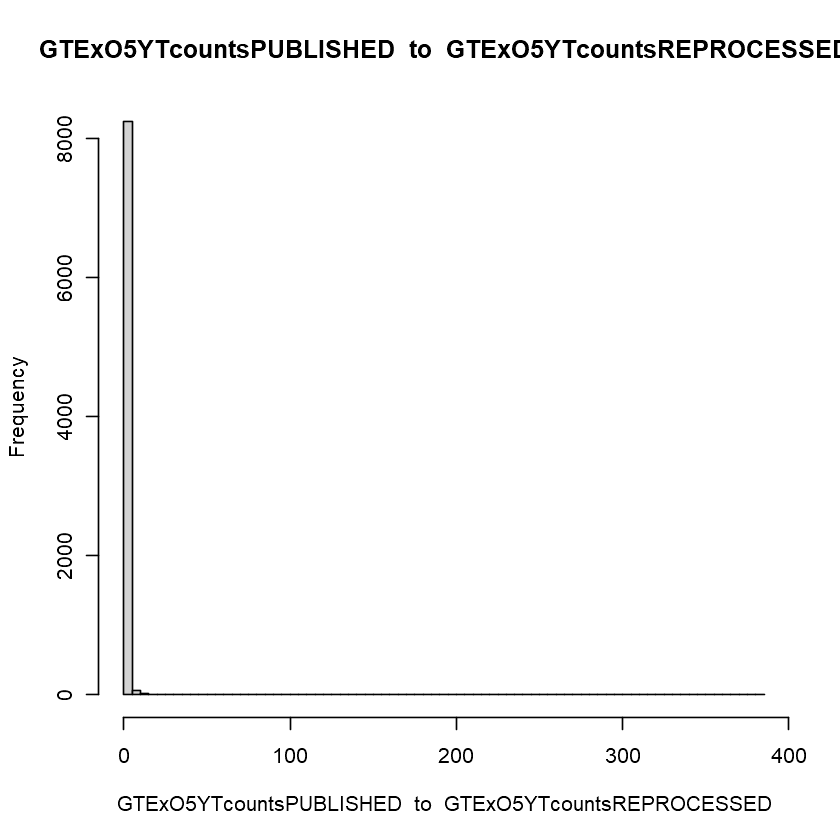

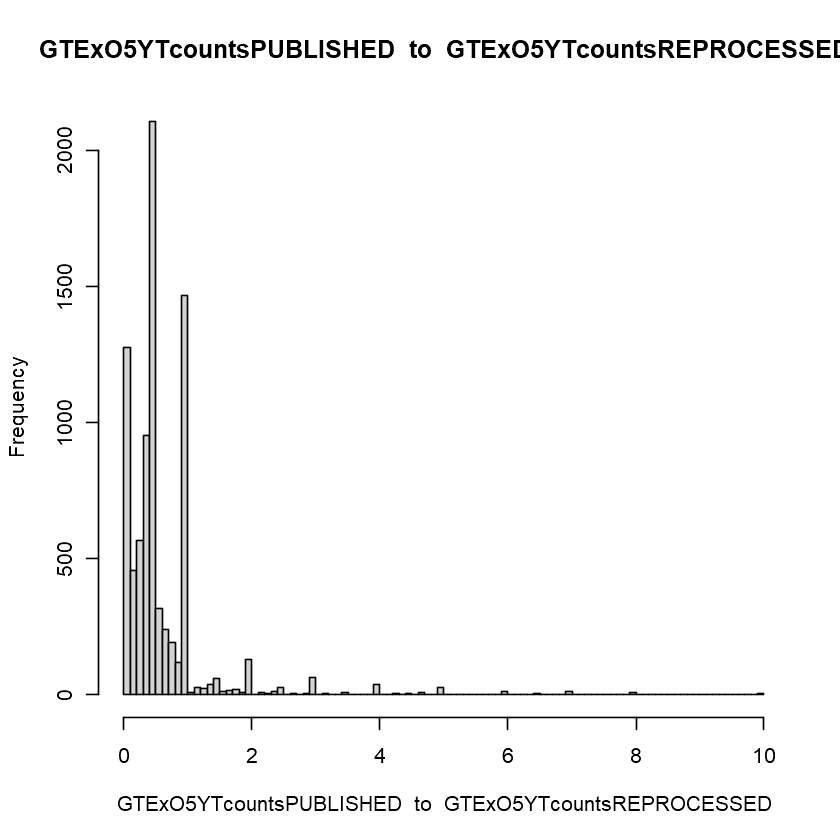

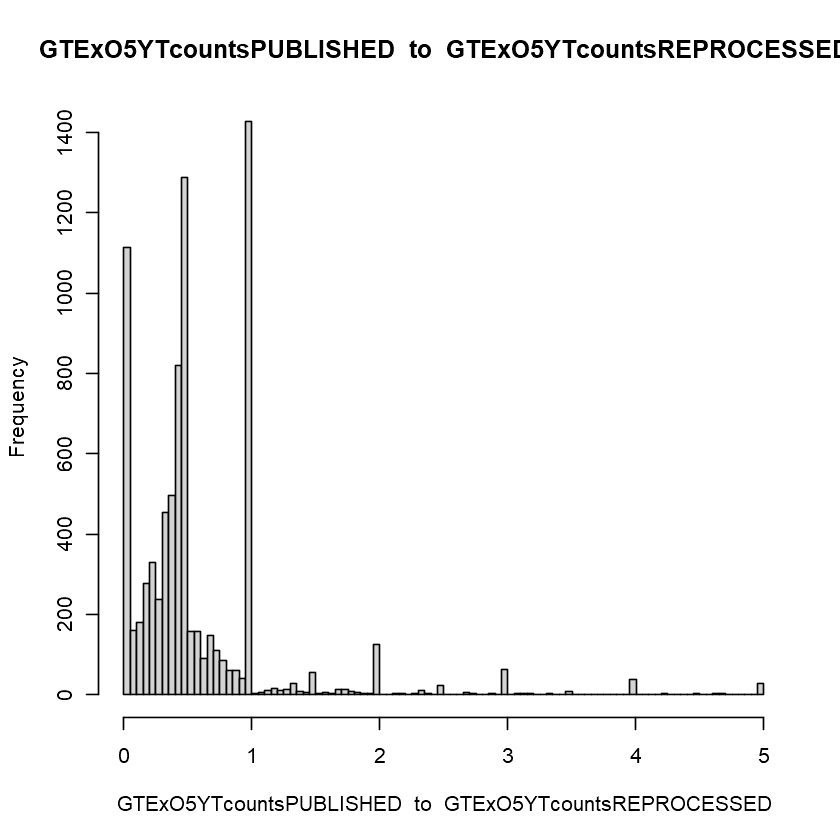

In [12]:
O5yt <- counts.df[,c(5,6)]
head(O5yt)

df <- O5yt
published <- 1
reprocessed <- 2

difference <- vector()
tozero <- vector()

name <- paste(colnames(df)[published], " to ", colnames(df)[reprocessed])

for (k in 1:nrow(df)) {
    if (df[k, published] == 0) { # "divide by zero" results in a seperate vector
        tozero <- append(tozero, df[k, reprocessed])
    } else {
        # relative change value calculated and stored in vector
        change <- abs(df[k, reprocessed] - df[k, published]) / df[k, published]
        difference <- append(difference, change)
    }
}

# histogram for all genes
hist(difference, main = name, xlab = name, nclass = 100)

# quantile
print("Quantile:")
quantile(difference, probs=c(0, 0.1, 0.25, 0.5, 0.75, 0.9, 1))

# number of genes statistics
print("Gene Statistics (difference total, difference > 0.5 to >10):")
length (difference)
length(which (difference > 0.5))
length(which (difference > 1))
length(which (difference > 5))
length(which (difference > 10))

# histogram for > 10 difference genes
rm.ind <- which (difference > 10)
difference2 <- difference[-rm.ind]

hist(difference2, main = name, xlab = name, nclass = 100)

# histogram for > 5 difference genes
rm.ind <- which (difference > 5)
difference3 <- difference[-rm.ind]
hist(difference3, main = name, xlab = name, nclass=100)